# DSCI 100 Group 14 Final Project
Fahad Alabdulwahed, Anson Chen, Gabriella Muller, Andrew Wong

# Can the player's experience level and age predict whether they are subscribed to the game newsletter?

### Introduction

This project will examine the playing habits of players logged on to Dr. Frank Wood’s Mine Craft server. Dr. Wood’s research group needs to figure out logistics surrounding hosting the server. In this project, we will focus on one specific question that will help Dr. Wood’s team in their recruitment efforts. The dataset has 2 files, `players.csv` and `sessions.csv`, but how question of interest will only utilize `player.csv`. With their broad question of: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?", we will be evaluating whether player's experience level and age can predict the subscription status of players to the game newsletter.

### Dataset
**Player Dataset**: `players.csv`, contains data on each unique player.<br>
Observations: 196, Variables: 7

| Variable|Description|Type|Mean (summary statistic)|
|:--------|:---|:-------|:-----|
|`experience`|experience of a player; Beginner, Amateur, Regular, Pro, Veteran|chr (character)|N/A|
|`subscribe`|if the player is subscribed to the game related newsletter|chr (character)| N/A|
|`hashedEmail`|ID of player|chr (character)| N/A|
|`played_hours`|number of hours played|dbl (numeric value with decimals)|5.845918|	
|`name`|name of the player|chr (character)|N/A|
|`gender`|gender of player|chr (character)|N/A|
|`age`|age of the player|dbl (numeric value with decimals)|21.13918|



# Methods and Results
### Loading Data into R and Wrangling It

In [55]:
library(tidyverse)
library(tidymodels)
library(repr)
library(dplyr)
library(rsample)
library(ggplot2)

Our goal is to predict subscription status of players based on age and experience. We will clean our data by selecting only Age, experience, and subscribe, from our dataset.

In [56]:
players_data <- read_csv("https://raw.githubusercontent.com/ansonansonnn/dsci100-project/refs/heads/main/players.csv")
head(players_data)

players_clean <- players_data|> drop_na()
players_selected <- players_clean|> select(Age, experience, subscribe)
head(players_selected)

summary(players_selected)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Age,experience,subscribe
<dbl>,<chr>,<lgl>
9,Pro,TRUE
17,Veteran,TRUE
17,Veteran,FALSE
21,Amateur,TRUE
21,Regular,TRUE
17,Amateur,TRUE


      Age         experience        subscribe      
 Min.   : 9.00   Length:194         Mode :logical  
 1st Qu.:17.00   Class :character   FALSE:52       
 Median :19.00   Mode  :character   TRUE :142      
 Mean   :21.14                                     
 3rd Qu.:22.75                                     
 Max.   :58.00                                     

### Summary Statistics of Our Data

In [57]:
players_summarised <- players_selected |>
    summarize( 
        mean_player_age = mean(Age),
        median_player_age = median(Age),
        min_age = min(Age),
        max_age = max(Age))
players_summarised

exp_count <- players_selected |>
    count(experience)
exp_count

sub_count <- players_selected |>
    count(subscribe)
sub_count

mean_player_age,median_player_age,min_age,max_age
<dbl>,<dbl>,<dbl>,<dbl>
21.13918,19,9,58


experience,n
<chr>,<int>
Amateur,63
Beginner,35
Pro,13
Regular,35
Veteran,48


subscribe,n
<lgl>,<int>
FALSE,52
TRUE,142


## Exploratory Analysis

We will use the KNN classification model with the `player.csv` dataset to answer our question. Because we am interested in predicting subscription status, a categorical variable, based on age and experience, KNN classification model seems like the best option.

### Visualizations

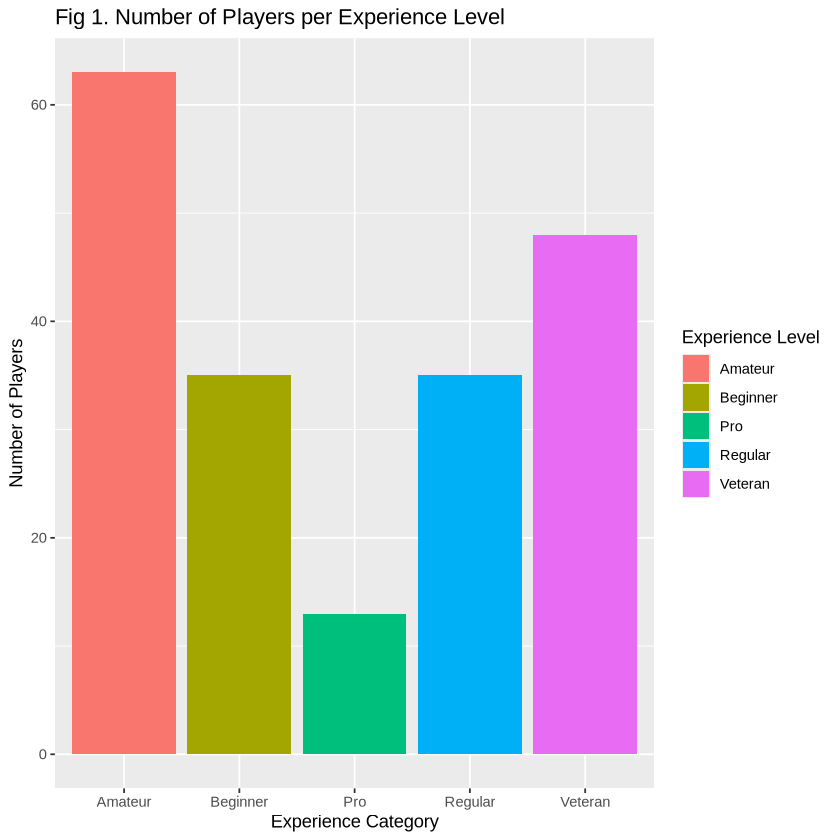

In [58]:
#1) bar plot by experience

experience_plot <- players_selected |>
    ggplot(aes(x = experience, fill = experience))+
    geom_bar(stat = "count")+
    labs(x = "Experience Category",
         y = "Number of Players",
         fill = "Experience Level",
         title = "Fig 1. Number of Players per Experience Level")
experience_plot

**Figure 1:** This fiure shows a bar plot of the number of players per experience level. Amateur players tend to be the most, then veterans, beginners = regulars, and pro with the fewest number of players.

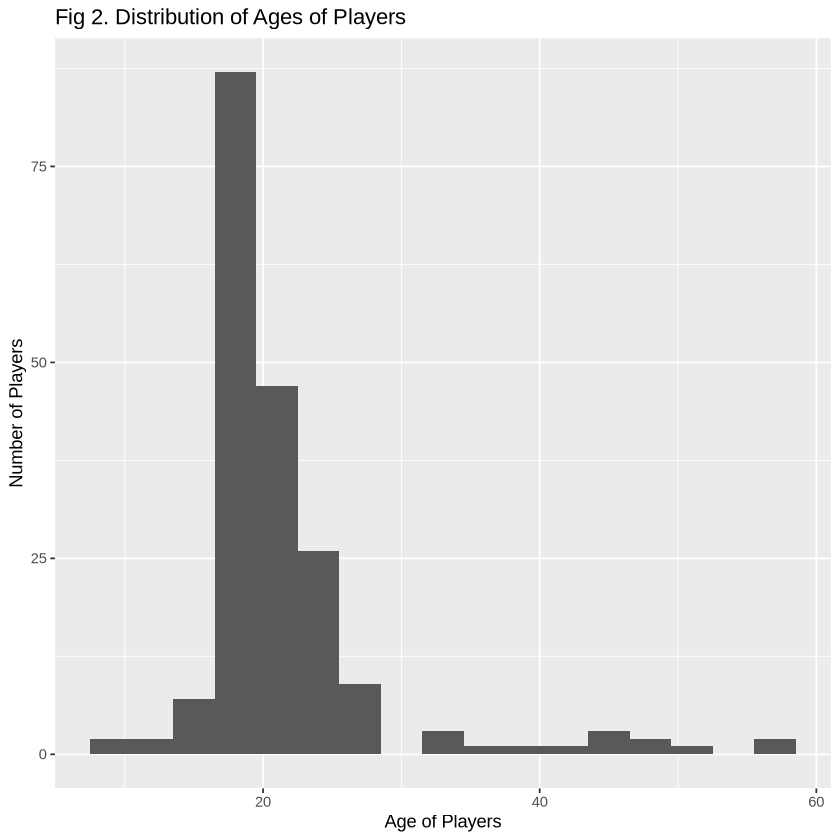

In [59]:
#2 distribution (histogram) by age

age_plot <- players_selected |>
    ggplot(aes(x = Age))+
    geom_histogram(binwidth = 3)+
    labs(x = "Age of Players",
         y = "Number of Players",
         title = "Fig 2. Distribution of Ages of Players")
age_plot

**Figure 2:** This figure shows the distribution of players in a histogram with the most players (a peak) around the age of 18-21.

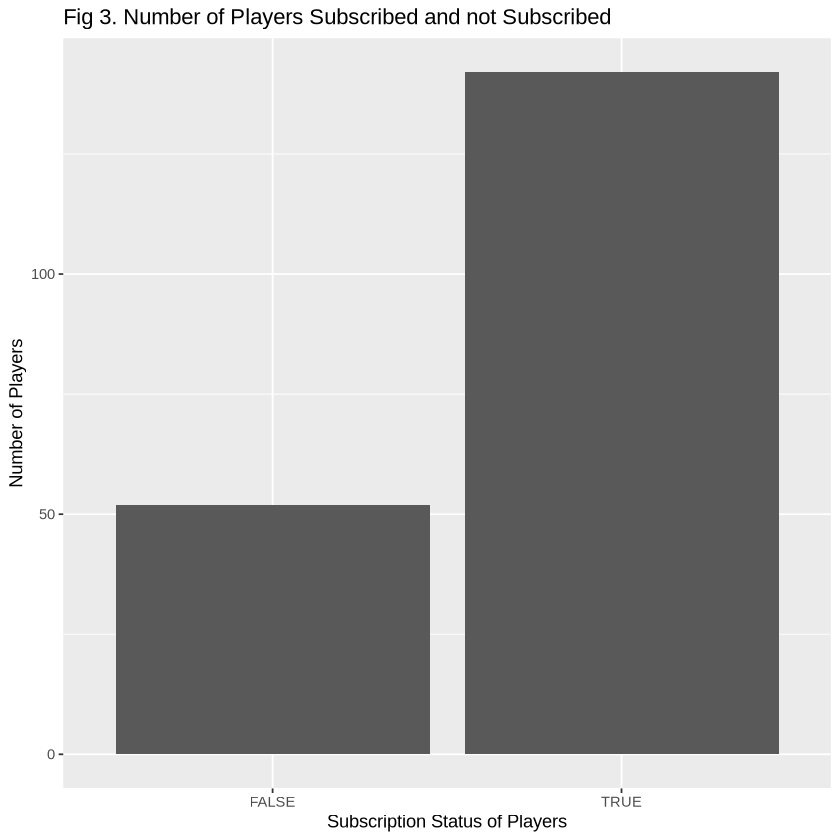

In [60]:
#3 bar plot of subsribtion status of players

subscribed_plot <- players_selected |>
    ggplot(aes(x = subscribe))+
    geom_bar()+
    labs(x = "Subscription Status of Players",
         y = "Number of Players",
         title = "Fig 3. Number of Players Subscribed and not Subscribed")
subscribed_plot

**Figure 3:** This figure shows a bar plot showing the number of players who are subscribed (TRUE column) and number of players who are not subscribed (FALSE column).

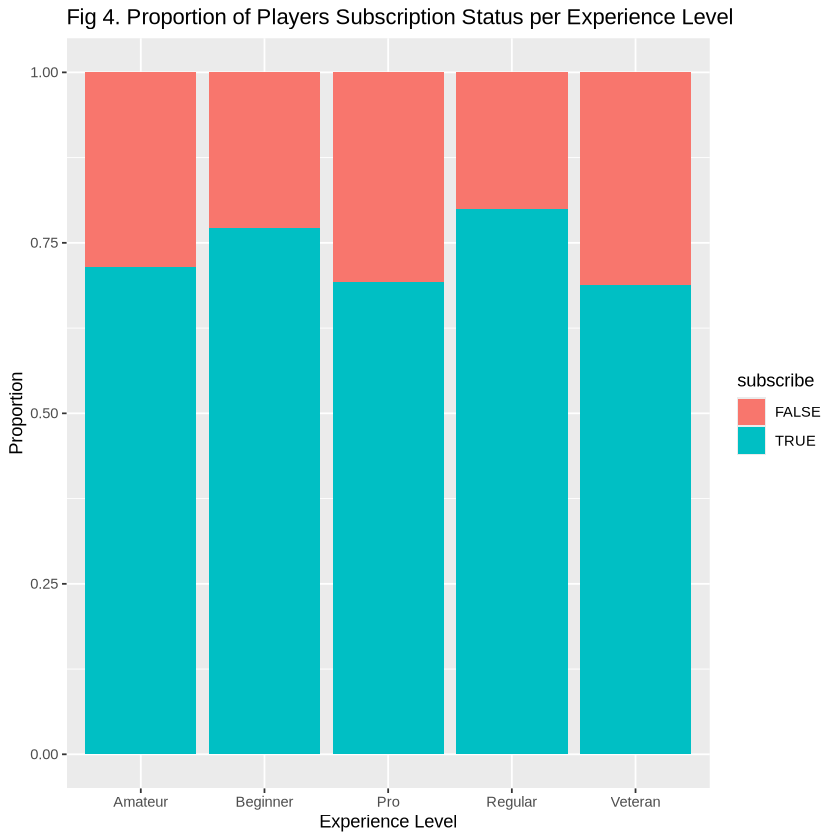

In [61]:
#4 proportional bar plot of subscription status and experience

players_selected |>
  mutate(experience = as.factor(experience)) |>
  ggplot(aes(x = experience, fill = subscribe)) +
  geom_bar(position = "fill") +
  labs(title = "Fig 4. Proportion of Players Subscription Status per Experience Level",
       y = "Proportion",
       x = "Experience Level")

**Figure 4:** This figure shows the proportion of players subscribed (TRUE) and not subscribed (FALSE) for each level of experience. We can see that regular and beginner players have the highest proportions of subscribed players while amateur, pro, and veteran have slightly lower proportion of subscribed players.

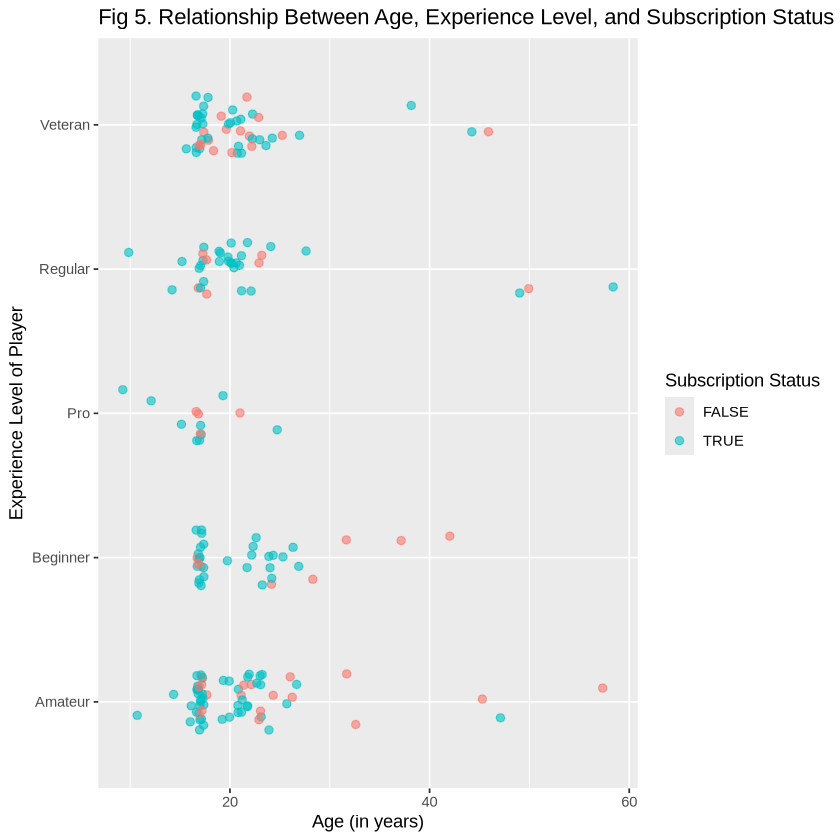

In [62]:
#5 jitter plot of subscription status based on age and experience level

all_variables_plot <- ggplot(players_selected, aes(x = Age, y = experience, color = subscribe))+
geom_jitter(height= 0.2, alpha = 0.6, size = 2)+
labs(x = "Age (in years)",
     y = "Experience Level of Player",
     color = "Subscription Status",
     title = "Fig 5. Relationship Between Age, Experience Level, and Subscription Status")
all_variables_plot

**Figure 5:** This figure shows a jitter plot of the relationship between age, experience level and subscription status. Age is on the x axis, experience level is on the y axis and each player is colored based on their subscription status (TRUE = subscribed, FALSE = not subscribed).

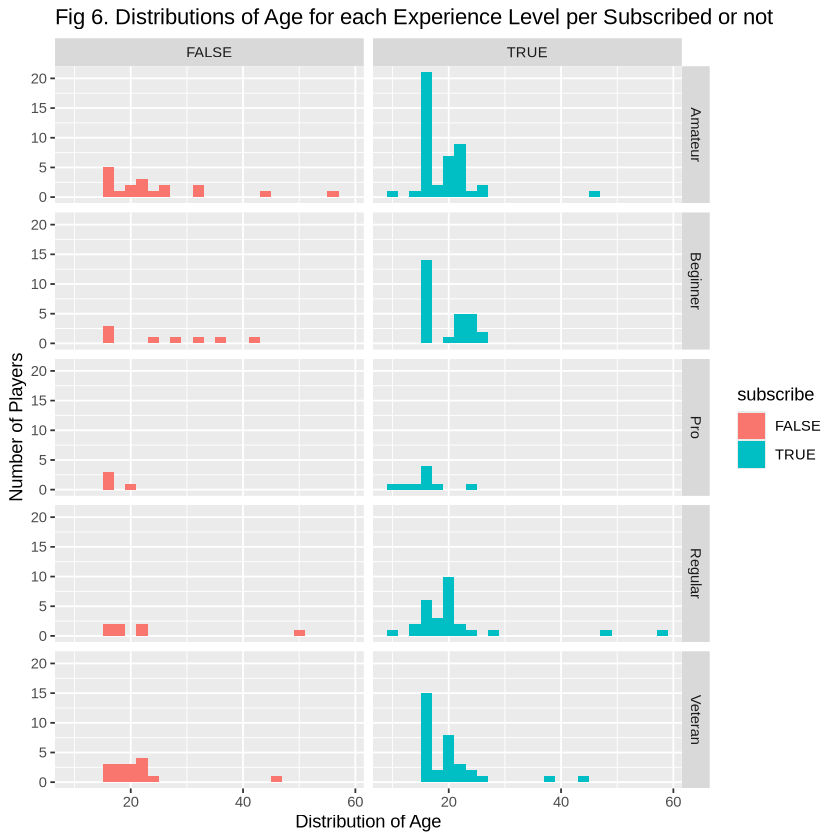

In [63]:
#6 Distributions (histograms) of age separated by experience level and subscription status
distributions_all <- ggplot(players_selected, aes(x = Age, fill = subscribe)) +
    geom_histogram(binwidth = 2) +
    facet_grid(experience ~ subscribe) +
    labs(x = "Distribution of Age",
         y = "Number of Players",
         title = "Fig 6. Distributions of Age for each Experience Level per Subscribed or not")
distributions_all

**Figure 6:** This figure shows 10 distributions of age, 5 of which are by experience level of subscribed players, and the other 5 by experience level of players that are not subscribed.

## Data Analysis

### 1) Wrangle and clean data

We are wrangling and cleaning the data by removing NA values, and also converting our categorical predictors to numerical because KNN classification works with distance (a numerical value). We also convert our response variable (subscribe) to a factor so our model can classify the subscription status as TRUE or FALSE.

In [64]:
set.seed(123)

# remove NA values, convert categorical predictors to numerical, convert response variable to factor (subscribed or not subscribed)
players_selected <- players_data |>
    drop_na() |>
    filter(!is.na(experience), !is.na(Age), !is.na(subscribe)) |>
    select(experience, Age, subscribe)

# convert experience to numeric 
players_selected <- players_selected |> 
    mutate(experience = as.numeric(factor(experience, levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran"))))

# convert subscribe to factor (subscribed or not subscribed)
players_selected <- players_selected |>
    mutate(subscribe = as.factor(factor(subscribe, levels = c(TRUE, FALSE), labels = c("subscribed", "not subscribed"))))

### 2) Training the Data, Finding Optimal K, Creating the Model

In this step, we are aiming to train our data and find the optimal k value. We split the data into a 70/30 train-test split. We scaled all our predictors, and we tuned our k using cross validation. We also used a five fold model to give our model more stability. We told the model to select the best k from our range of values, and our elbow plot below supports our decision to use k = 11.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5185389,5,0.036576301,Preprocessor1_Model1
6,accuracy,binary,0.6145910,5,0.015646585,Preprocessor1_Model2
11,accuracy,binary,0.7411477,5,0.014584591,Preprocessor1_Model3
16,accuracy,binary,0.7411477,5,0.014584591,Preprocessor1_Model4
21,accuracy,binary,0.7334554,5,0.005166822,Preprocessor1_Model5
26,accuracy,binary,0.7334554,5,0.005166822,Preprocessor1_Model6


[1] 11

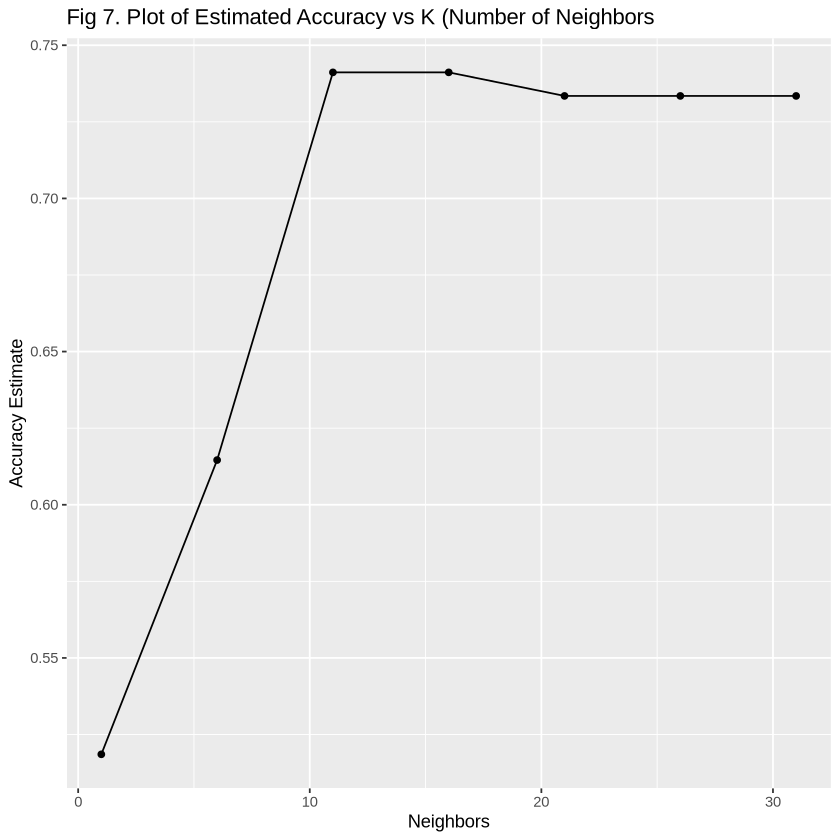

In [65]:
set.seed(123)

# splitting the data (train/test)
player_split <- initial_split(players_selected, prop = 0.70, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

# preprocess the data (create the preprocessing recipe)
player_recipe <- recipe(subscribe ~ Age + experience, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# tune K using cross-validation
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# split into v folds
player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

# create dataframe with values of K to try (1-100)
k_vals <- tibble(neighbors = seq(from = 1, to = 35, by = 5))

knn_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")
head(accuracies)

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors",
         y = "Accuracy Estimate",
         title = "Fig 7. Plot of Estimated Accuracy vs K (Number of Neighbors")
accuracy_vs_k

best_k <- accuracies |>
    arrange(desc(mean)) |>
    slice(1) |>
    pull(neighbors)
best_k

**Figure 7:** This figure shows the plot of accuracy estimate against number of neighbors (K). We can see the point(s)/values of K with the highest accuracy is 11 and 16. We will set K = 11 for our analysis for the highest accuracy estimate.

### 3) Retraining Training Data with Best K Value

In [66]:
set.seed(123)

# retrain the training data set with best K value

player_recipe <- recipe(subscribe ~ Age + experience, data = player_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_spec) |>
    fit(data = player_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(11,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2296296
Best kernel: rectangular
Best k: 11

### 4) Making Predictions on the Test Data and Assessing Accuracy

In [67]:
set.seed(123)

# make predictions and assess accuracy of model on test data
player_test_predictions <- predict(knn_fit, player_test) |>
    bind_cols(player_test)

player_test_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

player_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")

player_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")

confusion <- player_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7457627


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.75


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9767442


                Truth
Prediction       subscribed not subscribed
  subscribed             42             14
  not subscribed          1              2

### 5) Visualizations of Analysis

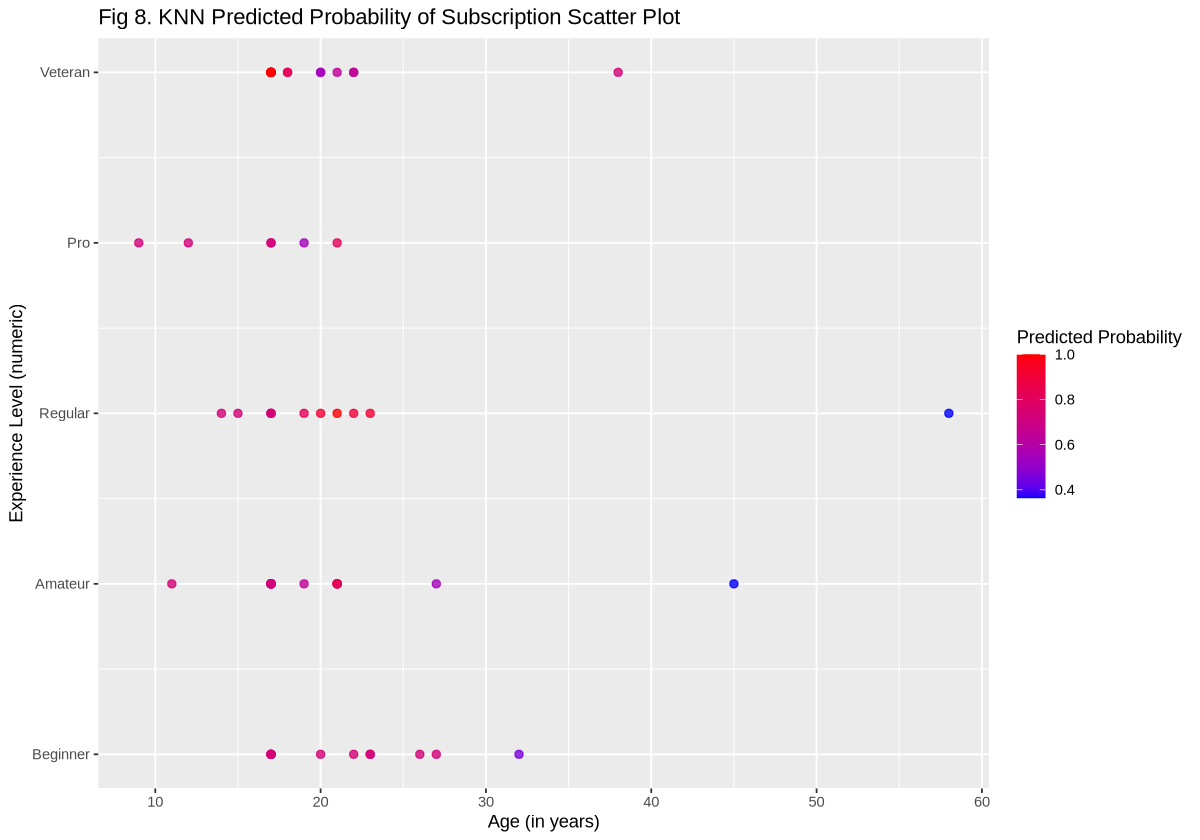

In [68]:
options(repr.plot.width = 10, repr.plot.length = 15)
knn_class <- predict(knn_fit, player_test, type = "prob") |>
bind_cols(player_test)

ggplot(knn_class, aes(x = Age, y = experience, color = .pred_subscribed))+
geom_point(size = 2, alpha = 0.8)+
scale_color_gradient(low = "blue", high = "red") +
scale_y_continuous(breaks = 1:5,
                   labels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")) +
labs(x = "Age (in years)",
     y = "Experience Level (numeric)",
     color = "Predicted Probability",
     title = "Fig 8. KNN Predicted Probability of Subscription Scatter Plot")

**Figure 8 Analysis:**
Here we see the predicted probability of newsletter subscription generated by the KNN classifier that is using the player's age and experience level as inputs. There are cooler and warmer colors to indicate the likelihood of subscription, cooler colors indicating a lower probability of subscription and warmer colors indicating a higher probability.
There doesn't seem to be a strong correlation between subscription status and experience level since we see higher probabilities of subscribing across all levels, probably indicating that majority of the players were subscribed. Age and subscription status don't seem to relate much either, we only see one outlier at a much higher age than the rest of the players with the lowest probability of subscribing.

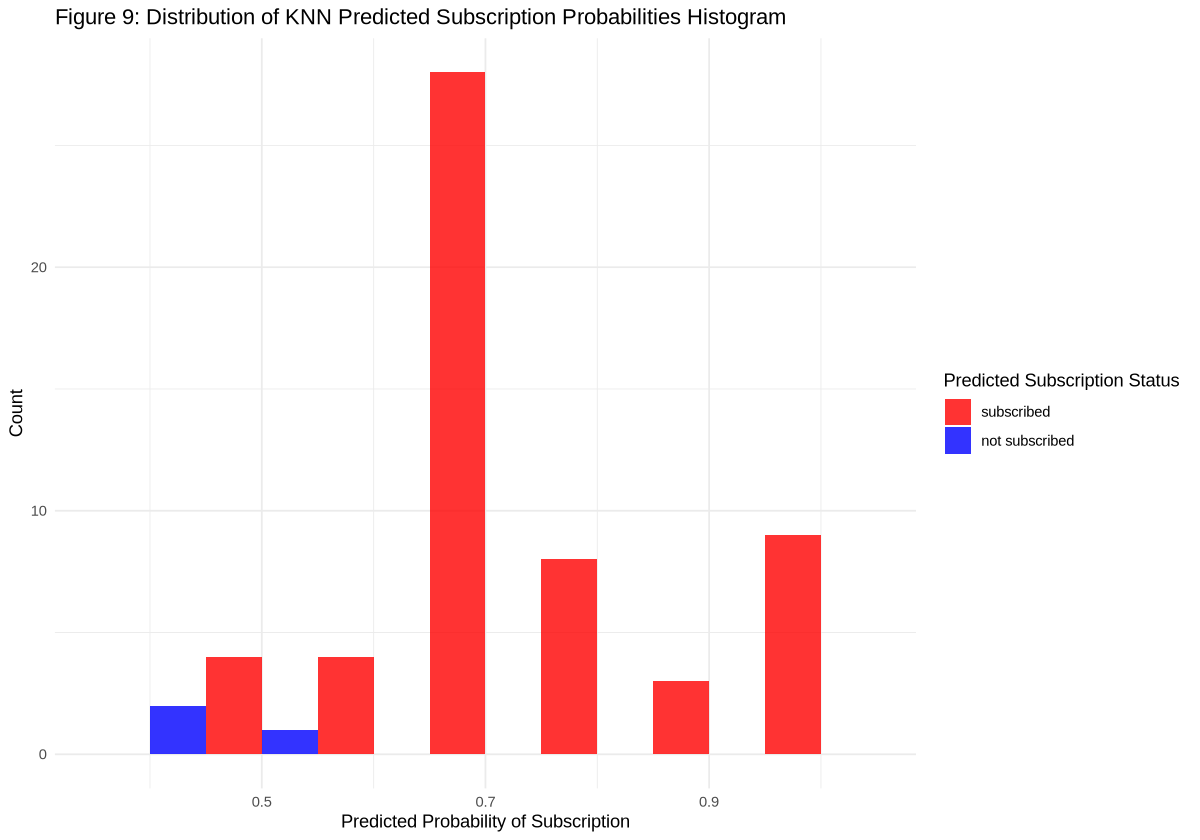

In [69]:
knn_prob <- predict(knn_fit, player_test, type= "prob") |>
bind_cols(player_test) |>
bind_cols(predict(knn_fit, player_test, type = "class"))

ggplot(knn_prob, aes(x= .pred_subscribed, fill= .pred_class))+
geom_histogram(binwidth= 0.1, alpha= 0.8, position= "dodge") +
scale_fill_manual(values= c("subscribed" = "red", "not subscribed" = "blue"))+
labs(x = "Predicted Probability of Subscription",
     y = "Count",
     fill = "Predicted Subscription Status",
     title = "Figure 9: Distribution of KNN Predicted Subscription Probabilities Histogram")+
theme_minimal()

**Figure 9 Analysis:**
Figure 9 complements Figure 8 by showing the distribution of predicted subscription probabilities from the KNN model along with the predicted subscription status of the players. We see the highest probabilities are "subscribed" players, and lower probabilities are "not subscribed" players, indicating the KNN model is more likely to classify more players as subscribed. 

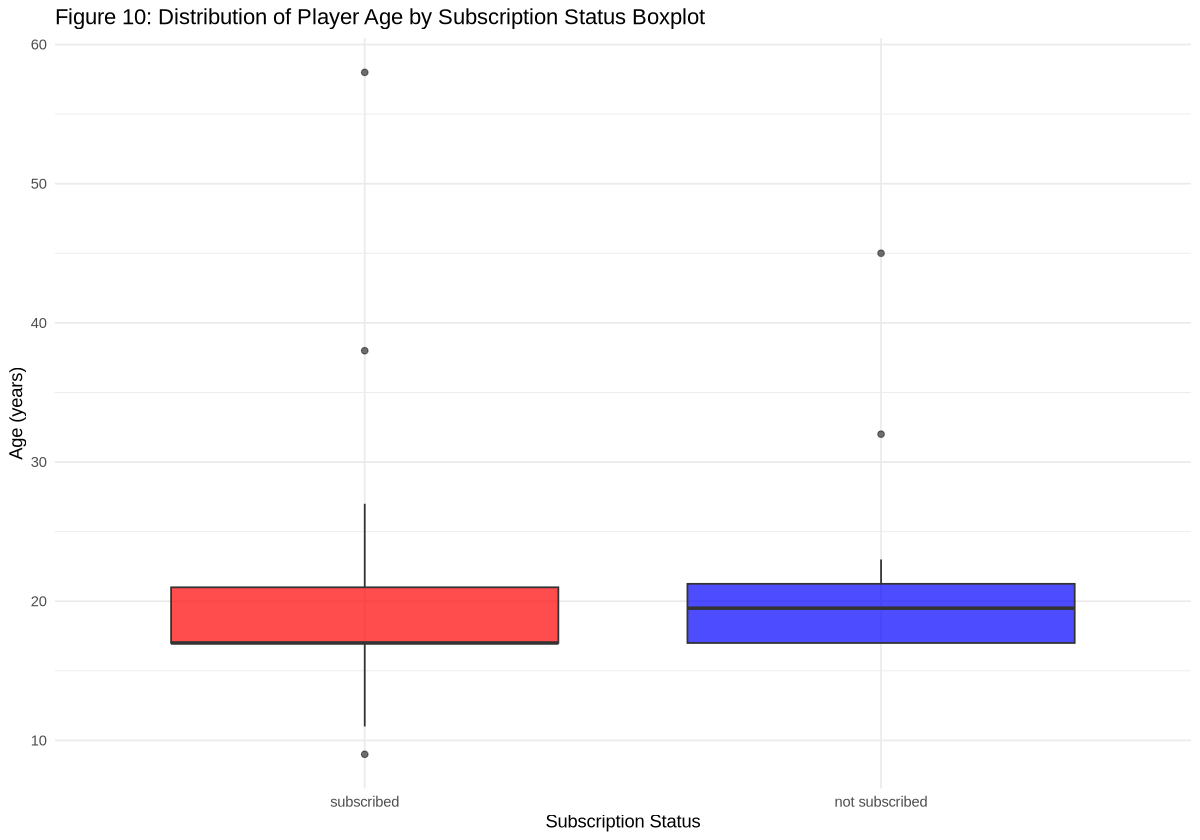

In [70]:
ggplot(player_test, aes(x= subscribe, y= Age, fill= subscribe))+
geom_boxplot(alpha= 0.7)+
labs(x= "Subscription Status",
     y= "Age (years)",
     title= "Figure 10: Distribution of Player Age by Subscription Status Boxplot")+
theme_minimal()+
scale_fill_manual(values= c("subscribed" = "red", "not subscribed" = "blue"))+
theme(legend.position= "none")

**Figure 10 Analysis:**
Here we see a boxplot showing the distribution of player ages, grouped by their subscription status to the newsletter. We see the median age between both subscribed and not subscribed is rather similar, so age might not be the strongest predictor of player subscription. There are older players who are outliers in the subscribed group, but overall the boxplot shows us that age varies among players and may not be the best insight in predicting subscription status.

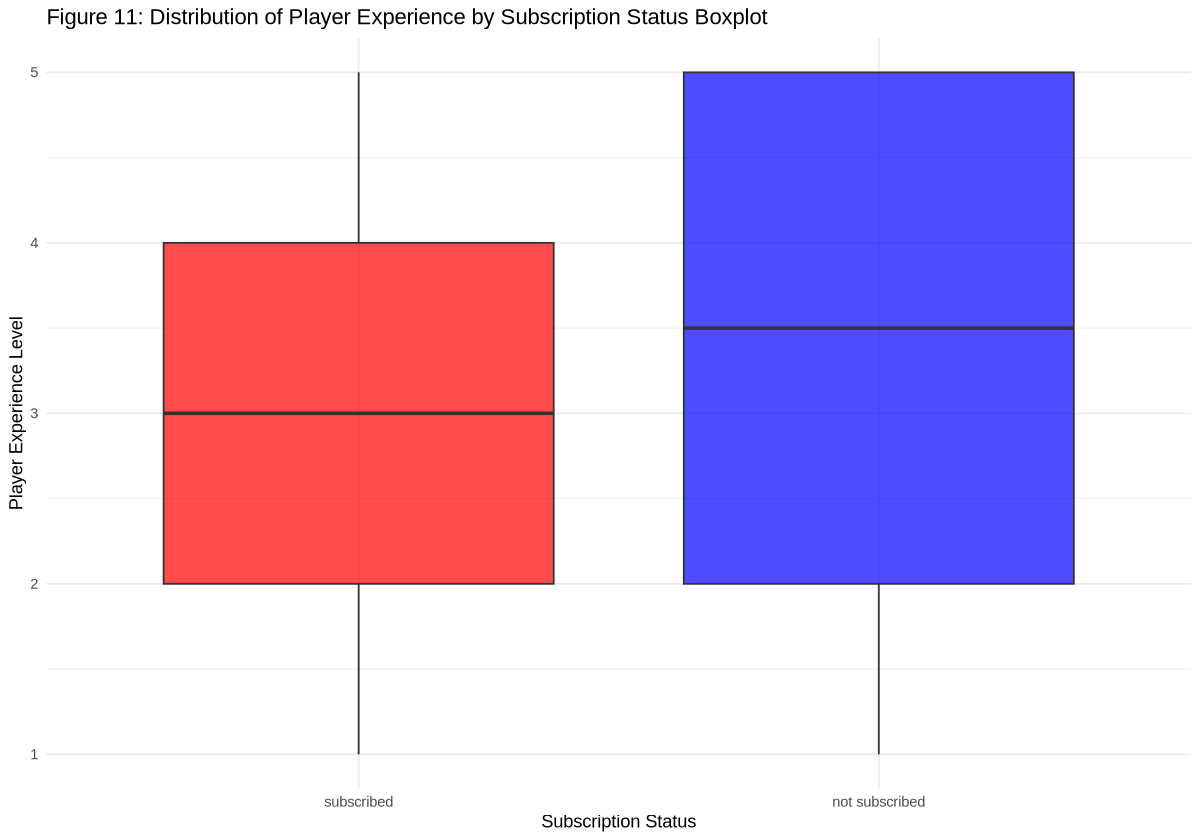

In [71]:
ggplot(player_test, aes(x= subscribe, y= experience, fill= subscribe))+
geom_boxplot(alpha= 0.7)+
scale_fill_manual(values= c("subscribed" = "red", "not subscribed" = "blue"))+
labs(x= "Subscription Status",
     y= "Player Experience Level",
     title= "Figure 11: Distribution of Player Experience by Subscription Status Boxplot")+
theme_minimal()+
theme(legend.position = "none")

**Figure 11 Analysis:**
In this boxplot we see the distribution of player experience levels grouped by the player's subscription status. We can see that the median experience level for not subscribed players is higher than the experience levels of subscribed players, the not subscribed experience levels also spread across a wider range of levels than subscribed players. This shows that this may be a stronger predictor of subscription status than age is. 